In [1]:
# importing needed libs

import numpy as np
# import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### Data preparation

In [2]:
# connecting to the database and obtaining ctr date for the users in 1 and 2 experimental groups
# for the period of time between 22 and 28 November inclusive

connection = {
    'host': '*******************',
    'password': '**************',
    'user': '********',
    'database': '***********'
}

query = """
SELECT
  user_id,
  exp_group,
  views,
  likes,
  ROUND(likes / views, 2) AS ctr
FROM
  (
    SELECT
      user_id,
      exp_group,
      sum(action = 'view') AS views,
      sum(action = 'like') AS likes
    FROM
      simulator_20241220.feed_actions
    WHERE
      toDate(time) >= '2024-11-22'
      AND toDate(time) <= '2024-11-28'
      AND exp_group in (2, 1)
    GROUP BY
      user_id,
      exp_group
  )
"""

# df = pandahouse.read_clickhouse(query, connection=connection)



In [3]:
# since I don't have connection to the clickhouse anymore I use the downloaded data 

df = pd.read_csv("ab_testing.csv")
df.head()

,user_id,exp_group,views,likes,ctr
0,109963,1,15,3,0.20
1,26117,1,141,32,0.23
2,138232,1,73,18,0.25
3,26295,1,141,39,0.28
4,18392,1,32,7,0.22


In [4]:
# checking that groups are about the same size

df.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


As we can see, the number of observations in the control and test groups is roughly the same. Let's take a visual look at the CTR distributions.

In [5]:
# devide and save data into two groups

control_group_ctr = df[df.exp_group == 1].ctr
test_group_ctr = df[df.exp_group == 2].ctr

Text(0.5, 0, 'CTR')

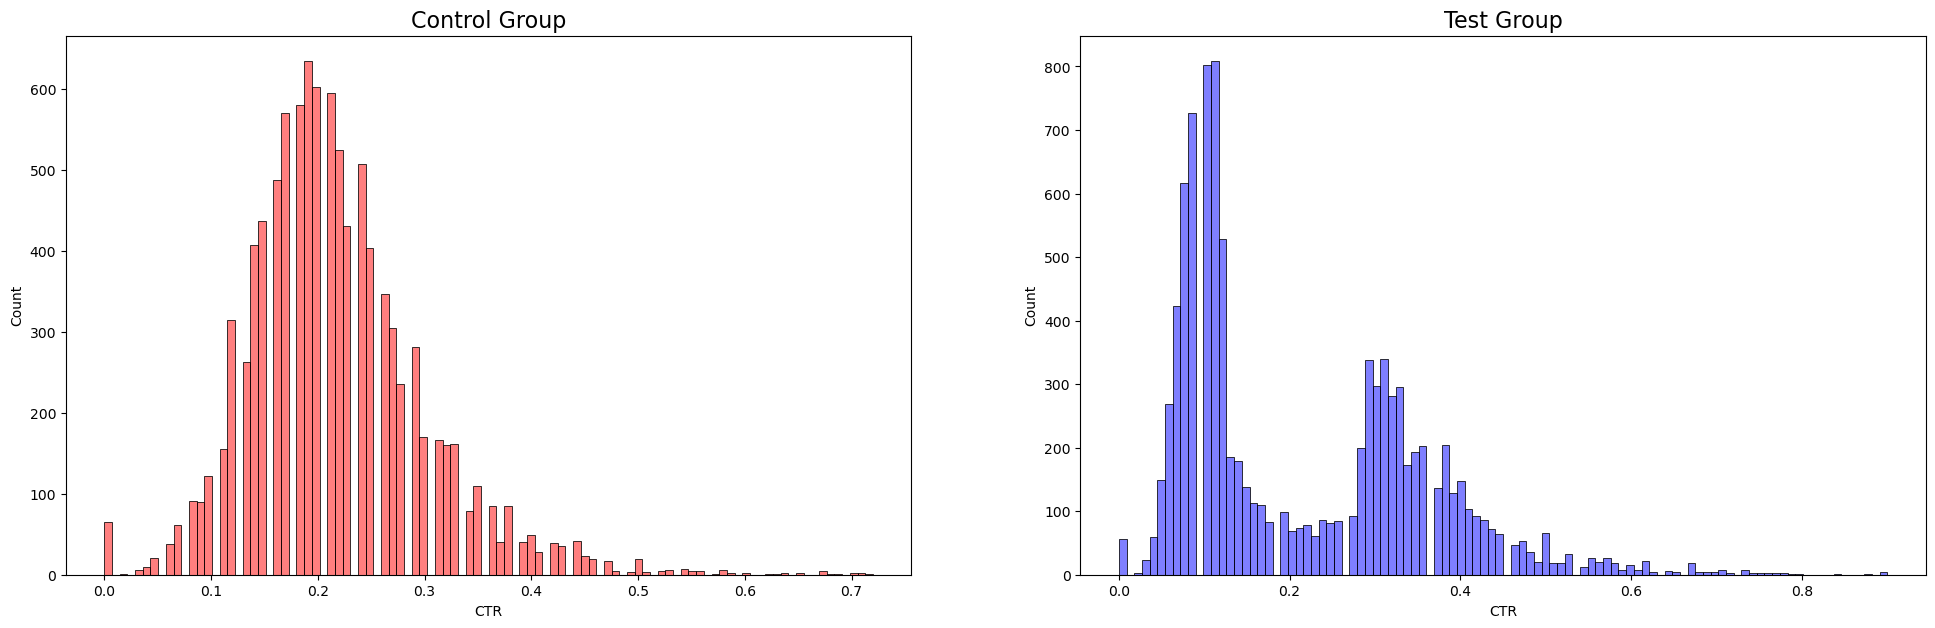

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(24, 7))

sns.histplot(ax=axs[0],
             x=control_group_ctr,
             color='r',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[0].set_title('Control Group', fontsize=16)
axs[0].set_xlabel('CTR')

sns.histplot(ax=axs[1],
             x=test_group_ctr,
             color='b',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[1].set_title('Test Group', fontsize=16)
axs[1].set_xlabel('CTR')

In the histograms of the data, it can be seen that the distribution for the control group is close to normal, while for the test group it is not. However, since the number of observations in both groups is large (about 10,000), a T-test can be performed, although the results should be interpreted with caution. Also, since it is not possible to assess the absolute values of the means from the graphs, they should be determined.

In [7]:
f"Average in control group is {control_group_ctr.mean().round(4)} and in test group is {test_group_ctr.mean().round(4)}"

'Average in control group is 0.2167 and in test group is 0.2161'

As can be seen above, the absolute values of the means differ only at the 4th decimal place, with the test group being smaller.

### T-test and Mann-Whitney U test

In [8]:
# counting t-test statistics

stats.ttest_ind(control_group_ctr,
                test_group_ctr,
                equal_var=False
               )[1]

0.6921668985029372

As it can be seen, the t-test showed a p-value greater than 0.05, which would not provide enough grounds to reject the null hypothesis if the distributions for both groups were normal. To expand the factual basis for making a decision about the benefit of the new algorithm, we will also conduct the U-test. As is known, the U-test tests the hypothesis of equality of medians, so it would be useful to know their absolute values for both groups.

In [9]:
control_group_ctr

0        0.20
1        0.23
2        0.25
3        0.28
4        0.22
         ... 
19886    0.18
19887    0.38
19890    0.19
19892    0.16
19893    0.19
Name: ctr, Length: 10020, dtype: float64

In [10]:
f"Median in control group is {control_group_ctr.median()} and in test group is {test_group_ctr.median()}"

'Median in control group is 0.21 and in test group is 0.15'

The median CTR in the control group is higher than in the test group, which may indicate a deterioration in the CTR of the new algorithm, and in this case, much more significantly.

In [11]:
# counting U-test statistics

stats.mannwhitneyu(control_group_ctr,
                test_group_ctr
               )[1]

6.509971658856411e-45

As seen, the U-test showed a p-value significantly less than 0.05, indicating a significant difference in the medians of the groups and the distributions as a whole.

It would be useful to look at the data after some transformation — specifically, Laplace smoothing — to stabilize them a bit. It is unlikely to normalize the distribution of the test group, but it’s worth trying.

### Data smoothing

In [12]:
# smoothing data function

def data_smoother(likes, views, global_ctr, alpha=5):
    smoothed_ctr = (likes + alpha * global_ctr) / (views + alpha)
    return smoothed_ctr

In [13]:
# deviding all data into two groups test and control and calculating global ctr for each group

df_control = df.query('exp_group == 1')
control_global_ctr = df.query('exp_group == 1').likes.sum() / df.query('exp_group == 1').views.sum()

df_test = df.query('exp_group == 2')
test_global_ctr = df.query('exp_group == 2').likes.sum() / df.query('exp_group == 2').views.sum()

In [14]:
# creating a new column applying smothing function

df_control['smoothed_ctr'] = data_smoother(df_control.likes,
                                   df_control.views,
                                   control_global_ctr,
                                   alpha=5
                                  )

df_test['smoothed_ctr'] = data_smoother(df_test.likes,
                                   df_test.views,
                                   test_global_ctr,
                                   alpha=5
                                  )

C:\Users\Alexey\AppData\Local\Temp\ipykernel_8608\2397296315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control['smoothed_ctr'] = data_smoother(df_control.likes,
C:\Users\Alexey\AppData\Local\Temp\ipykernel_8608\2397296315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['smoothed_ctr'] = data_smoother(df_test.likes,


Text(0.5, 0, 'CTR')

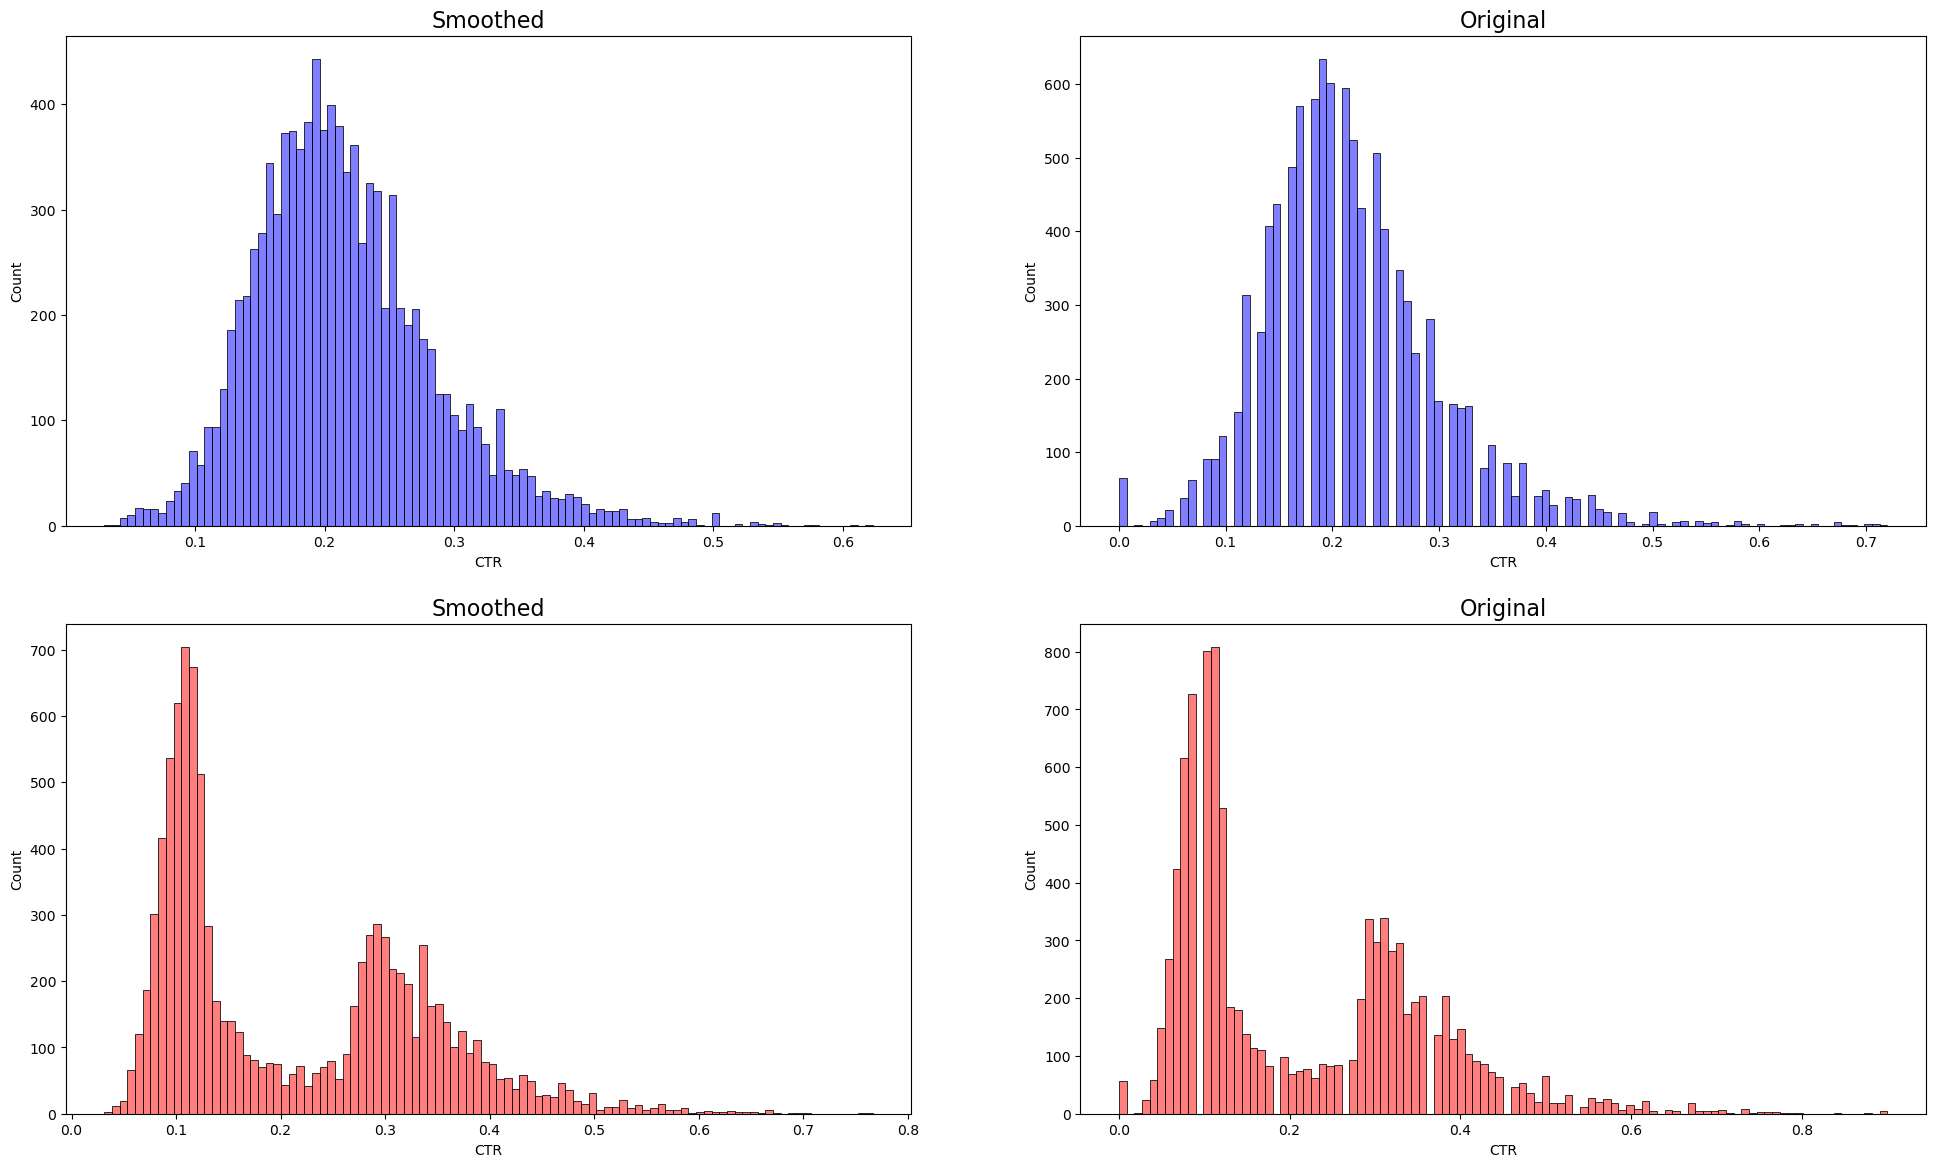

In [15]:
# creating two plots to compare Smoothed CTR with the original CTR for the TEST group

fig, axs = plt.subplots(2, 2, figsize=(24, 14))

sns.histplot(ax=axs[0, 0],
             x=df_control['smoothed_ctr'],
             color='b',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[0, 0].set_title('Smoothed', fontsize=16)
axs[0, 0].set_xlabel('CTR')

sns.histplot(ax=axs[0, 1],
             x=df_control.ctr,
             color='b',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[0, 1].set_title('Original', fontsize=16)
axs[0, 1].set_xlabel('CTR')

sns.histplot(ax=axs[1, 0],
             x=df_test['smoothed_ctr'],
             color='r',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[1, 0].set_title('Smoothed', fontsize=16)
axs[1, 0].set_xlabel('CTR')

sns.histplot(ax=axs[1, 1],
             x=df_test.ctr,
             color='r',
             alpha=0.5,
             kde=False,
             bins=100
            )
axs[1, 1].set_title('Original', fontsize=16)
axs[1, 1].set_xlabel('CTR')

After smoothing the data, the graphs became smoother, and this especially helped eliminate data with a CTR of 0. However, this still didn't solve the main problem – the abnormal distribution of CTR in the test group. Nevertheless, let's try applying the T-test and U-test to the smoothed data.

In [16]:
stats.ttest_ind(df_control['smoothed_ctr'], df_test['smoothed_ctr'], equal_var=False)[1]

0.05166679015318526

In [17]:
stats.mannwhitneyu(df_control['smoothed_ctr'], df_test['smoothed_ctr'])[1]

2.396534039374286e-50

You can see that the U-test still shows significant differences, but despite the fact that the T-test still showed a p-value above 0.05, this time it is approximately equal to the threshold value. In any case, smoothing did not play a significant role, so for further analysis, we will resort to the Poisson Bootstrap.

### Bootstrap

In [18]:
# poisson bootstrap function that receives likes and views of both groups,
# counts weight for every user by their number of likes and their encounter frequency,
# then concidering these weights counts global ctr for both groups

def bootstrap(likes_control,
              views_control,
              likes_test,
              views_test
             ):
    
    weight_control = stats.poisson(1).rvs((2000, len(likes_control))).astype(np.int64)
    weight_test = stats.poisson(1).rvs((2000, len(likes_test))).astype(np.int64)
    
    bootstraped_ctr_control = (weight_control * likes_control).sum(axis=1) / (weight_control * views_control).sum(axis=1)
    bootstraped_ctr_test = (weight_test * likes_test).sum(axis=1) / (weight_test * views_test).sum(axis=1)
    
    return bootstraped_ctr_control, bootstraped_ctr_test

In [19]:
# deviding data into likes and views for both groups

likes_control = df_control.likes.to_numpy()
views_control = df_control.views.to_numpy()
likes_test = df_test.likes.to_numpy()
views_test = df_test.views.to_numpy()

In [20]:
# counting global weight CTRs for both groups

bootstraped_ctr_control, bootstraped_ctr_test = bootstrap(likes_control,
                                                          views_control,
                                                          likes_test,
                                                          views_test
                                                         )

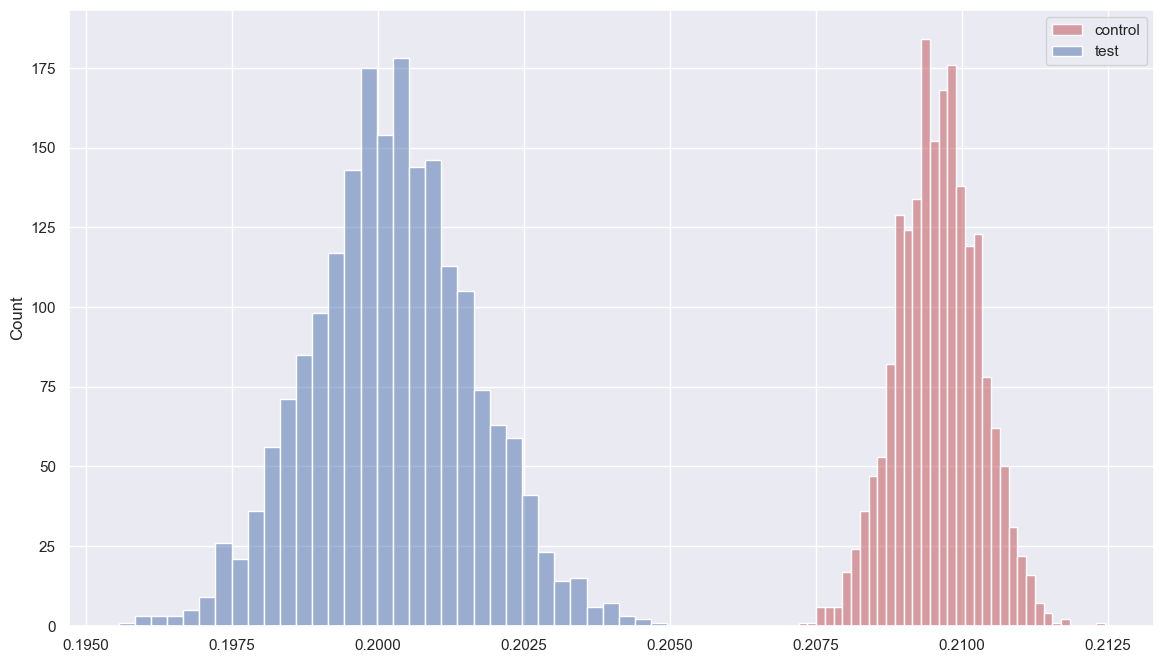

In [21]:
# making a graph

sns.set(rc={'figure.figsize':(14, 8)})

sns.histplot(x=bootstraped_ctr_control,
             kde=False,
             label='control',
             color='r',
             alpha=0.5
            )
sns.histplot(x=bootstraped_ctr_test,
             kde=False,
             label='test',
             color='b',
             alpha=0.5
            )
plt.legend()

Even without conducting a t-test on the histograms of the bootstrapped data shown above, it is clear that the CTR in the test group is significantly different from the CTR in the control group. It is also apparent that the CTR of users in the test group is still lower than in the control group.

In [22]:
# just to make sure

stats.ttest_ind(bootstraped_ctr_control, bootstraped_ctr_test, equal_var=False)[1]

0.0

You can see, p-value < 0.05

At the moment, the data is sufficient to make a decision about implementing the new algorithm.

### Explanations

**Why the tests worked this way?**

The main reason why the tests worked out the way they did, in my opinion, is that the CTR distribution for the test group differs from the CTR distribution for the control group and is far from normal.

**Why did such a change occur?**

The first thing that stands out on the histogram of the CTR for the test group is bimodality, which is not present on the histogram of the CTR for the control group. The exact cause of this change cannot be determined without a more in-depth analysis.

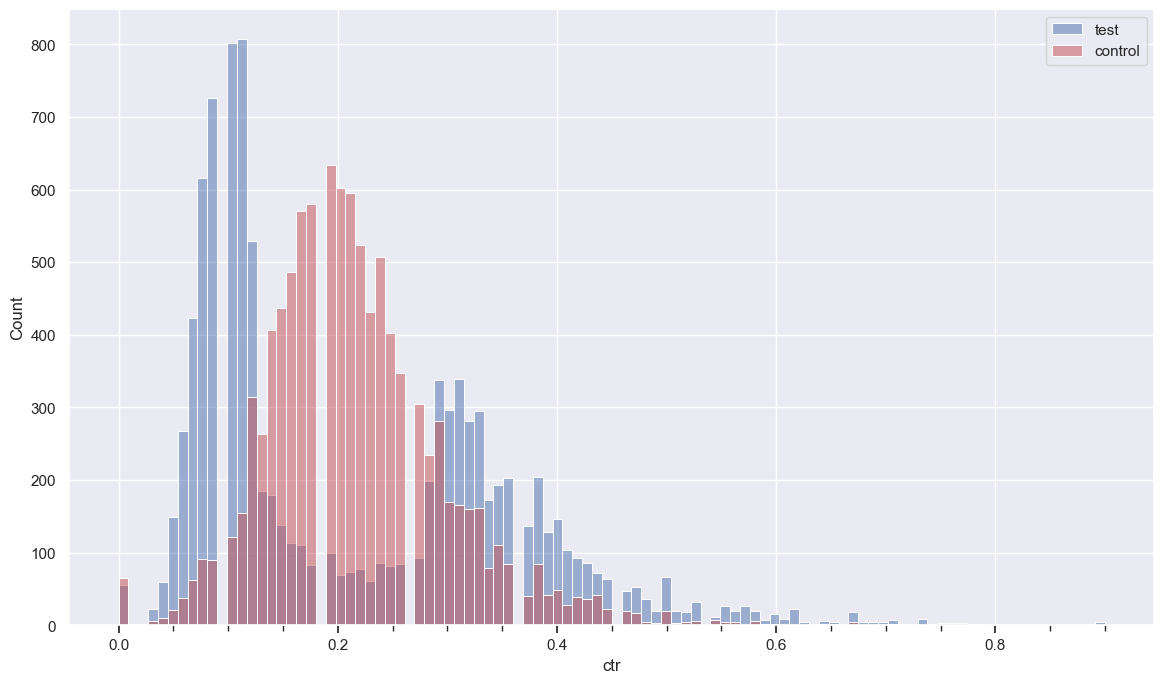

In [23]:
# first of all assessing the data visually
sns.set(rc={'xtick.bottom': True, 'figure.figsize':(14, 8)})

groups = sns.histplot(data=df,
                    x='ctr',
                    hue='exp_group',
                    palette=['r', 'b'],
                    alpha=0.5,
                    kde=False,
                    bins=100
)

groups.legend(labels=['test', 'control'])
groups.minorticks_on()

Since the histogram of the test group shows two peaks on both sides of the peak of the control group's histogram, it can be assumed that part of the users liked the algorithm, while part did not. As a result, both the proportion of those who started liking more and the proportion of those who started liking less have increased. However, it should be ensured that the new algorithm did not overall affect the audience's activity. To do this, we should at least check the total number of views.

In [24]:
f"Sum of views in control group is {df.query('exp_group == 1').views.sum()} \
and in test group is {df.query('exp_group == 2').views.sum().sum()}"

'Sum of views in control group is 669543 and in test group is 659454'

Since the absolute number of views in both groups is proportional, the change in CTR is most likely due to the change in the number of likes, rather than a decline in audience activity. It would also be interesting to know the proportion of users whose CTR increased and the proportion of those whose CTR decreased.

In [25]:
df_control_median = df.query('exp_group == 1').ctr.median()

lower_med = round(df.query('exp_group == 2 and ctr < @df_control_median').count()[0] * 100 / df.query('exp_group == 2').count()[0], 2)
higher_med = round(df.query('exp_group == 2 and ctr >= @df_control_median').count()[0] * 100 / df.query('exp_group == 2').count()[0], 2)

f"In the CTR distribution of the test group {higher_med}% of users now have CTR higher and\
 {lower_med}% lower compared to the median value of the CTR data of the control group"

C:\Users\Alexey\AppData\Local\Temp\ipykernel_8608\3572823477.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_med = round(df.query('exp_group == 2 and ctr < @df_control_median').count()[0] * 100 / df.query('exp_group == 2').count()[0], 2)
C:\Users\Alexey\AppData\Local\Temp\ipykernel_8608\3572823477.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_med = round(df.query('exp_group == 2 and ctr < @df_control_median').count()[0] * 100 / df.query('exp_group == 2').count()[0], 2)
C:\Users\Alexey\AppData\Local\Temp\ipykernel_8608\3572823477.py:4: FutureWarning: Series.__getitem__ treating keys as positions 

'In the CTR distribution of the test group 44.95% of users now have CTR higher and 55.05% lower compared to the median value of the CTR data of the control group'

As seen above, the CTR of most users in the test group decreased relative to the median CTR of the control group. Unfortunately, this once again confirms that, most likely, the number of people who did not like the algorithm is greater than the number of those who did.

**Recommendation for the Implementation of the New Algorithm**

As a result of comparing the data for the control and test groups, it was found that:

- The data shows significant differences expressed in the distribution of CTR.
- The data shows significant differences reflected in the p-value obtained by applying a t-test on bootstrapped data and a u-test on the original data.
- The absolute values of medians and means on the original data are lower in the test group than in the control group.
- On bootstrapped data, the CTR of users in the test group is lower than in the control group.
- In the test group, the number of users with CTR below the median CTR value of the test group has increased.
- In conclusion, it can be stated that the new recommendation algorithm performs worse than the current one.

Recommendations:
1. Implementing the new algorithm for all users is not advisable, as it has shown significant worse results.
2. Since there is a portion of users whose CTR increased, there is a reason to further refine the algorithm.